In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
kernel = "alpha" # psc kernel "alpha" or "exp"

neuron_model = [
    "edlif_psc_"+kernel+"_percent.nestml",
    "iaf_psc_"+kernel
]

# Choose noise type
noise = "poisson_generator" # noise_generator (gaussian) or poisson_generator
# more info here:
# https://nest-simulator.readthedocs.io/en/v2.18.0/models/generator.html#classnest_1_1ac__generator
exc_mean = 100 # mean value of noise current (pA). Only for Gaussian
exc_std = exc_mean/10
inh_mean = 100
inh_std = inh_mean/10
exc_rate = 100000 # Only for poisson
inh_rate = 100000

# weights
noise_exc_w = 1.*2
noise_inh_w = -1.*1

# neuron threshold
th = -55 # default value: -55

# seed
seed = 1

# sim time
sim_time = 1000

nest.Install("nestmlmodule")
nest.set_verbosity("M_WARNING")


Aug 23 21:58:57 Install [Info]: 
    loaded module nestmlmodule


In [3]:
def bombard_neuron(neuron_id, seed):
    nest.ResetKernel()
    nest.rng_seed = seed
    neuron_model_name = neuron_model[neuron_id].split(".")[0]
    print(f"Using neuron model: {neuron_model_name}")

    neuron = nest.Create(neuron_model_name)
    if th != -55:
        if neuron_model_name=="iaf_psc_exp":
            neuron.V_th = th
        else:
            neuron.V_th = th
    exc_noise = nest.Create(noise)
    inh_noise = nest.Create(noise)
    mult = nest.Create("multimeter", params={'record_from':['V_m']})
    sr = nest.Create('spike_recorder')

    if noise == "noise_generator":
        exc_noise.mean = exc_mean
        exc_noise.std = exc_std
        inh_noise.mean = inh_mean
        inh_noise.std = inh_std
    elif noise == "poisson_generator":
        exc_noise.rate = exc_rate  
        inh_noise.rate = inh_rate  
    
    # connections
    syn_dict_noise_exc = {"weight": noise_exc_w}
    syn_dict_noise_inh = {"weight": noise_inh_w}
    nest.Connect(exc_noise, neuron, syn_spec=syn_dict_noise_exc)
    nest.Connect(inh_noise, neuron, syn_spec=syn_dict_noise_inh)

    nest.Connect(mult, neuron)
    nest.Connect(neuron, sr)
    nest.Simulate(sim_time)

    vm = mult.get('events', 'V_m')
    spk_times = sr.get('events', 'times')
    return vm, spk_times 

In [4]:
def plot_vm(vm, s_times):
    plt.figure(figsize=(12, 6))
    #fig, ax = plt.subplots(nrows=2, figsize=(15,12))
    plt.plot(vm, label="voltage")
    spks = np.ones(len(s_times))*-50
    plt.plot(s_times, spks, 'o', color='orange', label="spike times")
    plt.xlabel('time')
    plt.ylabel('Voltage (mV)')
    plt.legend()

Using neuron model: edlif_psc_alpha_percent


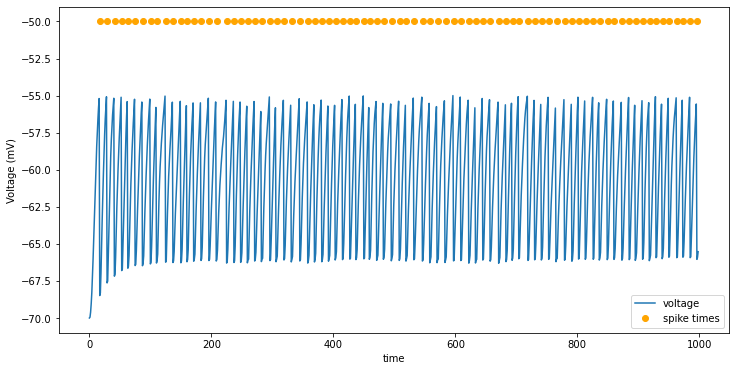

In [5]:
# Choose neuron model
neuron_id = 0 # edlif (0) or iaf (1)
vm_edlif, s_times_edlif = bombard_neuron(neuron_id, seed)
plot_vm(vm_edlif, s_times_edlif)

Using neuron model: iaf_psc_alpha


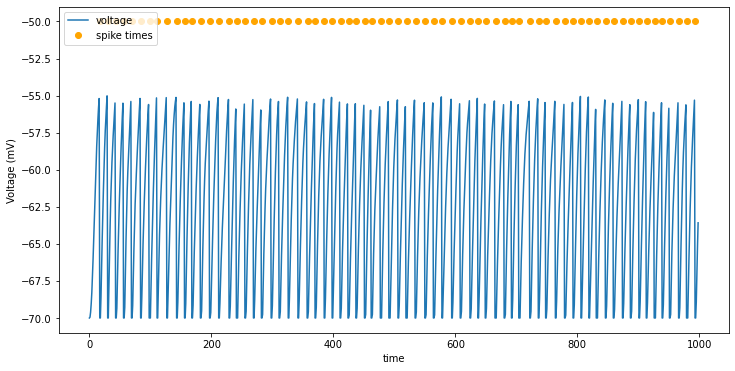

In [6]:
# Choose neuron model
neuron_id = 1 # edlif (0) or iaf (1)
vm_lif, s_times_lif = bombard_neuron(neuron_id, seed)
plot_vm(vm_lif, s_times_lif)

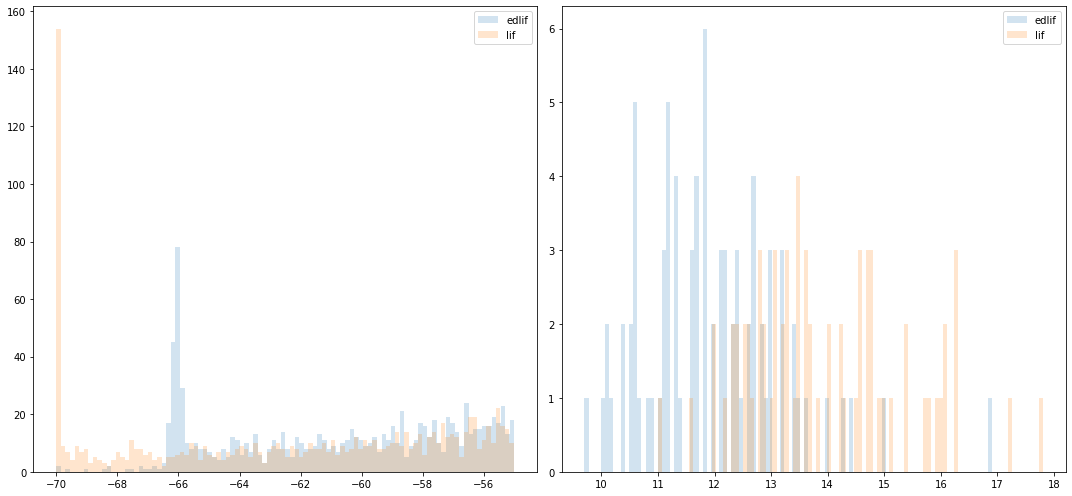

In [7]:
alpha = 0.2
n_bins = 100
def plot_hist(vm_edlif, vm_lif, isi_edlif, isi_lif):
    fig, ax = plt.subplots(1, 2,
                            figsize =(15, 7),
                            tight_layout = True)
    ax[0].hist(vm_edlif, bins=n_bins, alpha=alpha, label="edlif")
    ax[0].hist(vm_lif, bins=n_bins, alpha=alpha, label="lif")

    ax[1].hist(isi_edlif, bins=n_bins, alpha=alpha, label="edlif")
    ax[1].hist(isi_lif, bins=n_bins, alpha=alpha, label="lif")

    for x in ax:
        x.legend()
        
isi_edlif = s_times_edlif[1:] - s_times_edlif[:-1]
isi_lif = s_times_lif[1:] - s_times_lif[:-1]
plot_hist(vm_edlif, vm_lif, isi_edlif, isi_lif)

In [8]:
print(s_times_lif)
print(isi_lif)

[ 17.4  30.1  43.7  56.7  69.6  84.3  99.  111.2 127.2 143.5 156.6 168.6
 182.8 197.8 212.4 229.6 242.  255.8 269.4 282.9 298.6 311.8 326.3 342.4
 357.8 370.7 385.4 398.2 411.7 424.9 437.7 451.9 462.9 478.  492.  506.6
 520.  534.8 550.9 564.9 578.2 594.5 608.8 624.7 637.3 649.7 666.  680.9
 692.5 705.  722.8 736.4 748.7 764.5 779.9 793.6 806.1 819.2 832.  846.6
 859.7 874.5 887.8 901.5 913.5 927.  939.6 951.9 966.7 980.  993.5]
[12.7 13.6 13.  12.9 14.7 14.7 12.2 16.  16.3 13.1 12.  14.2 15.  14.6
 17.2 12.4 13.8 13.6 13.5 15.7 13.2 14.5 16.1 15.4 12.9 14.7 12.8 13.5
 13.2 12.8 14.2 11.  15.1 14.  14.6 13.4 14.8 16.1 14.  13.3 16.3 14.3
 15.9 12.6 12.4 16.3 14.9 11.6 12.5 17.8 13.6 12.3 15.8 15.4 13.7 12.5
 13.1 12.8 14.6 13.1 14.8 13.3 13.7 12.  13.5 12.6 12.3 14.8 13.3 13.5]
